In [1]:
# Download and Extract Cifar-10 batch files
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz

--2025-07-20 10:12:06--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  49.0MB/s    in 3.6s    

2025-07-20 10:12:09 (45.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [97]:
# import packages
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [98]:
# Open and load batch-1 from cifar dataset
with open('cifar-10-batches-py/data_batch_1', 'rb') as fo:
    batch = pickle.load(fo, encoding='bytes')
# show batch keys
print(batch.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [99]:
# Extract data and labels
data = batch[b'data']
labels = batch[b'labels']

In [100]:
# In Cifar-10 dataset
# 0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"

In [101]:
# find 20 images for birds, cats, deers, dog and horse
bird_image = []
cat_image = []
deer_image = []
dog_image = []
horse_image = []

for img, lbl in zip(data, labels):
    if lbl == 2 and len(bird_image) != 20:
        bird_image.append(img)
    if lbl == 3 and len(cat_image) != 20:
        cat_image.append(img)
    if lbl == 4 and len(deer_image) != 20:
        deer_image.append(img)
    if lbl == 5 and len(dog_image) != 20:
        dog_image.append(img)
    if lbl == 7 and len(horse_image) != 20:
        horse_image.append(img)

    if len(bird_image) == 20 and len(cat_image) == 20 and len(deer_image) == 20 and len(dog_image) == 20 and len(horse_image) == 20:
        break

print("Number of bird images", len(bird_image))
print("Number of cat images", len(cat_image))
print("Number of deer images", len(deer_image))
print("Number of dog images", len(dog_image))
print("Number of horse images", len(horse_image))

Number of bird images 20
Number of cat images 20
Number of deer images 20
Number of dog images 20
Number of horse images 20


In [102]:
# Equally distribute the classes inside the new 100 image dataset
# New labels
# 0: "bird", 1: "cat", 2: "deer", 3: "dog", 4: "horse"

img_dataset = []

for bird, cat, deer, dog, horse in zip(bird_image, cat_image, deer_image, dog_image, horse_image):
    img_dataset.append({"image": bird, "label": 0})
    img_dataset.append({"image": cat, "label": 1})
    img_dataset.append({"image": deer, "label": 2})
    img_dataset.append({"image": dog, "label": 3})
    img_dataset.append({"image": horse, "label": 4})

print(len(img_dataset))

100


In [103]:
# check dimension of image
print(img_dataset[0]["image"].shape)

(3072,)


In [104]:
# write function for splitting according to crossfold number
def split_data(dataset, crossfold):
  if crossfold < 1 or crossfold > 5:
    print("Invalid crossfold number")
    return [], [], [], []

  test_set = []
  train_set = []

  test_start = (crossfold - 1) * 20
  test_end = crossfold * 20

  test_set = dataset[test_start:test_end]
  train_set.extend(dataset[:test_start])
  train_set.extend(dataset[test_end:])

  # split image and label as x and y
  x_test = []
  y_test = []
  x_train = []
  y_train = []

  for img in test_set:
    x_test.append(img["image"])
    y_test.append(img["label"])

  for img in train_set:
    x_train.append(img["image"])
    y_train.append(img["label"])

  return x_test, x_train, y_test, y_train

In [105]:
# calculate manhattan distance for all test image
def calcManhattanDistance(x_test, x_train, y_train):

  dist = []

  for test_img in x_test:
    temp_dist = []
    for train_img, train_lbl in zip(x_train, y_train):
      distance = np.sum(np.abs(test_img - train_img))
      temp_dist.append({"distance": distance, "label": train_lbl})

    temp_sorted = sorted(temp_dist, key=lambda x: x["distance"])
    dist.append(temp_sorted)

  return dist

In [106]:
from collections import Counter

# write classifying function using kNN
def kNNclassifier(dist, k):
  prediction = [] # store predictions for all test image

  for img in dist:
    labels = [neighbor["label"] for neighbor in img[:k]]
    most_common_label = Counter(labels).most_common(1)[0][0]
    prediction.append(most_common_label)

  return prediction

In [117]:
# calculate accuracy function
def accuracy(dist, y_train, k):
  pred = kNNclassifier(dist=dist, k=k)

  correct_predictions = 0
  for i in range(len(pred)):
    if pred[i] == y_train[i]:
      correct_predictions += 1

  accuracy = 100 * correct_predictions / len(pred)
  return accuracy


In [125]:
# calculate accuracy for 5-folds

acc = []
dist = []

for k in range(1, 81):
  acc_fold = []
  for fold in range(1, 6):
    x_test, x_train, y_test, y_train = split_data(dataset=img_dataset, crossfold=fold)
    dist = calcManhattanDistance(x_test=x_test, x_train=x_train, y_train=y_train)
    acc_fold.append(accuracy(dist=dist, y_train=y_train, k=k))

  acc.append(acc_fold)

print(len(acc))

80


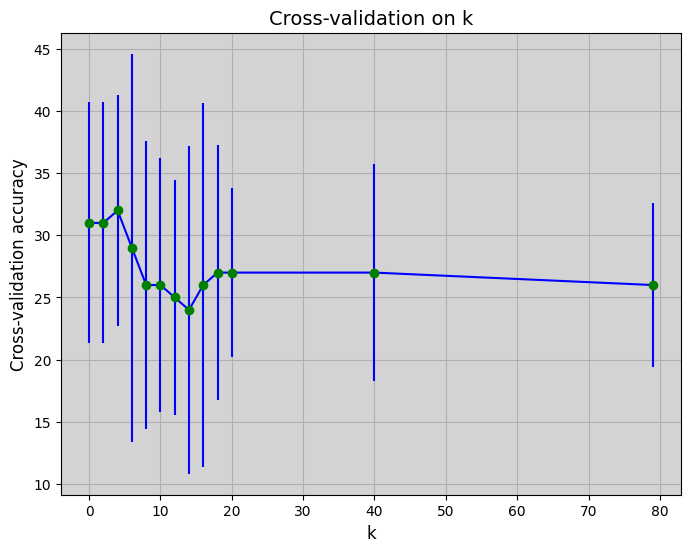

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data for illustration
k_values = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 40, 79]
acc = np.array(acc)

mean_accuracy = []
std_accuracy = []

for k_index in range(len(k_values)):
    mean = np.mean(acc[k_index])
    std = np.std(acc[k_index])
    mean_accuracy.append(mean)
    std_accuracy.append(std)

# Plot the data
plt.figure(figsize=(8, 6))
plt.errorbar(k_values, mean_accuracy, yerr=std_accuracy, fmt='o', color='green', ecolor='blue')

# Connect the data points with a line
plt.plot(k_values, mean_accuracy, color='blue')

# Add labels and title
plt.title("Cross-validation on k", fontsize=14)
plt.xlabel("k", fontsize=12)
plt.ylabel("Cross-validation accuracy", fontsize=12)
plt.grid(True)
plt.gca().set_facecolor('lightgray')  # Background color
plt.show()
